POSYDON Summer School 2025 <br />
Initial Final Interpolation Tutorial <br />
Prepared by Philipp M. Srivastava <br />

In [1]:
from posydon.grids.psygrid import PSyGrid
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from utils import show_figure

# 1.0 Introduction
As a POSYDON user, you may wonder how we simulate binaries that are not only accurate, but also efficient enough to enable the synthesis of populations containing millions of binaries. Among other factors, the main reason for our efficiency without sacrificing accuracy is the use of highly accurate machine learning (ML) systems. The most prevalent of these systems is the so-called initial-final interpolator. To understand this naming convention, let's begin by examining the steps within a typical binary evolution. The figure below shows just one possibility of the many different evolutionary possibilties, and each possible step within binary evolution is typically quite computationally expensive. In this particular example the two stars both start in a Hydrogen burning phase, until one of them enters a Helium burning phase causing mass transfer and then a collapse into a black hole via supernova, yielding a high mass X-ray binary. Next, the black hole and its companion enter a common envelope stage prior to the companion entering its own Helium burning phase with mass transfer. Finally, the companion collapses into a pulsating neutron star which merges with its companion black hole, emitting gravitational waves detectable to us. So how can we go about modelling so many physically rich and thereby computationally expensive steps efficiently?

Source: [1]


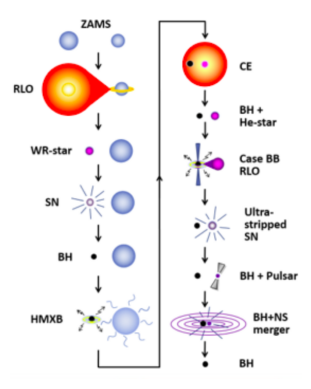

In [2]:
show_figure("binary_evolution.png", "[1]")

The key is to notice that most evolutionary paths are comprised of two main components: first, relatively long periods of time during which the stars or celestial objects undergo stellar evolution with binary interactions, and second, relatively short periods of time when the binary system undergoes violent and defining changes. While the latter steps usually consist of very rich physical processes that must be modelled with carefully constructed prescriptions, the former can be modelled by employing ML models which can effectively skip these phases by predicting binary's final values (stellar masses, orbital period, etc.), given its values at the beginning of each phase. It should be noted that these parameters typically do not include the profile of each star in the binary, and that the nearest neighbor must be used if the stellar profile information are desirable. We define a total of three phases which a binary could enter and be modelled by an ML system:

1. HMS-HMS, when both stars begin at the zero age main sequence (ZAM) and undergo Hydrogen burning.
2. CO-HMS RLO, when the primary star is burning Hydrogen and is in a roche lobe overflow (RLO) state with its companion which has collapsed into a compact object.
3. CO-HeMS, when the primary star is burning Helium while its companion has collapsed into a compact object.

Employing this paradigm, the first figure evolves into the one given below. Notice that each of the phases has been replaced with two bars, a pink one and a purple one. The pink represents the parameters describing the celestial objects at the beginning of the phase, while the purple one correspoonds to those parameters at the end of the phase.

Source: [1]


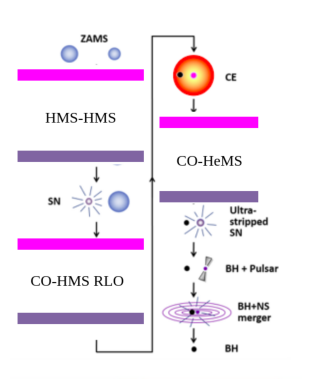

In [3]:
show_figure("./binary_evolution_with_IF.png", "[1]")

## 1.1 Theoretical description of the initial-final interpolator
The initial-final interpolation problem can conveniently be viewed as a regression problem, which has been well-studied in the ML community. In order to solve the problem, each of the mentioned three phases are modelled repeatedly using the famous code modules for experiments in stellar astrophysics (MESA) [3], where for each system modelled, the initial masses and orbital period are varied. This sampling of initial values form a grid $G = \{\mathbf{i}_1, \mathbf{i}_2, \dots, \mathbf{i}_N\}$, where $\mathbf{i}_j = (M^j_1, M^j_2, P_{orb})$, (the primary mass, secondary mass, and orbital period), and $N$ is the number of initial values in $G$. It should be noted that, the initial values are sampled in $\log$  space, which yields a higher resolution in low mass and orbital period values. Physcally, this makes sense, because systems with a higher orbital period will have less binary interactions and therefore don't require as fine of a resolution. To predict the final values of a system with an initial value of $\mathbf{i}_*$, an intuitive approach is to take the linear combination of the final values corresponding to initial values in $G$ with the smallest euclidean distance to $\mathbf{i}_*$. However, based on the trajectory of the simulation, we can expect the final values to differ drastically. For example, often the process of computing the solutions with MESA becomes unstable during the mass transfer (MT) phase due to a common envelope (CE), which prompts the simulation to be stopped and treated by a CE prescription. Clearly those final values will be quite different from those PDE solutions which did not enter CE, and therefore, it does not make sense to consider those final values together. To address this, we define a total of four classes:

1. Stable MT
2. Stable reverse MT
3. Unstable MT
4. No MT
5. Initial MT

With the initial MT class being one that we do not wish to find final values for.

<div class='alert alert-success'>

### Exercise 1

To solidify our understanding, let's take a look at the HMS-HMS grid and explore how we might address the problem of finding which linear combination of initial values we should take in order to compute final values. Below, a lot is filled in already:

1. We load in one of the POSYDON v2 grids
2. We grab the initial values data frame from the grid
3. We also grab the `interpolation_class` labels from the grid
4. We select a mass ratio (secondary / primary star mass) of `0.5` to plot 
6. We store the `interpolation_class` labels as a dictionary that we can use to color our stellar models from the grid with, at this mass ratio

Your task is to complete the `scatter` plot call below to plot the initial `period_days` (i.e., orbital period) vs. the initial `star_1_mass` (i.e., primary star mass), using the interpolation classes as colors for the scatter plot's markers. This will give us a visualization of the interpolation classes at this particular mass ratio slice, from this particular grid.

</div>

In [ ]:
grid_path = "/projects/e33022/POSYDON-shared/data/POSYDON_data/HMS-HMS/1e+00_Zsun.h5" # fill me in!

grid = PSyGrid(grid_path) # loading in grid
initial_values = np.array(grid.initial_values[["star_1_mass", "star_2_mass", "period_days"]].tolist())
mass_ratio = initial_values[:, 1] / initial_values[:, 0] # The HMS-HMS grid is sampled across mass ratio
class_labels = grid.final_values["interpolation_class"] # this contains an array where each elemnt is a class
# corresponding to each initial value
labels = np.unique(class_labels)

"""
defining which mass ratio our grid slice should correspond to and which delta deviation from that
grid slice is acceptable to consider an initial value part of the grid slice
"""
mr, delta = 0.5, 0.05

slice_inds = np.where((mass_ratio < mr + delta) & (mass_ratio > mr - delta)) # filtering to find slice
class_labels = class_labels[slice_inds] # filtering to get classes
label_colors = ["tab:purple", "tab:blue", "black", "tab:olive", "tab:green", "tab:red"]
color_dict = dict(zip(labels, label_colors)) # choose your colors

colors = [color_dict[label] for label in class_labels]

# plotting
fig, ax = plt.subplots(1, 1, figsize = (5, 5))

scatter = ax.scatter(
    # give the mass in log space for this slice, 
    # give the orbital period in log space for this slice, c = colors)
    
# FILL ME IN ^



ax.set_xlabel("log (mass 1)")
ax.set_ylabel("log (orbital period)")
ax.set_title(f"Grid slice at q = {mr}")

patches = [mpatches.Patch(color=color, label=label) for color, label in zip(label_colors, labels)]
legend = ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc="upper left", title="Legend")

<div class="alert alert-warning" style="margin-top: 20px">
<details>
    
<b><summary>Solution (click to reveal):</summary></b>

```python
np.log10(initial_values[:, 0][slice_inds]), # notice that we plot the initial values in log space
np.log10(initial_values[:, 2][slice_inds], c = colors)
```
    
</details>

To classify an initial value $\mathbf{i}_*$, we utilize a $k$-nearest neighbor approach, where $k$ is optimized using a validation set, and the weight of each neighbor $\mathbf{i}_j \in \mathscr{N}_*$ is set to be $d^-2$, where $d$ is the euclidean distance between the neighbor and the initial value of interest and $\mathscr{N}_*$ is the neighborhood of $\mathbf{i}_*$. $k$-nearest neighbors is widely known and a rather simple algorithm so we direct the reader to this [wikipedia page](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) for a refresher. Instead, we will focus on the more interesting process of the interpolation itself. A naiive way to solve the interpolation problem, which is still commonly used, is to use the nearest neighbor with the same class that $\mathbf{i}_*$ was classified as, to approximate the final value corresponding to $\mathbf{i}_*$. A more refined approach is to use use multiple final values corresponding to multiple neighbors to find a weighted average value. To do this, we utilize a lesser known, but powerful algorithm known as barycentric interpolation, which is based on barycentric coordinates [4]. Barycentric coordinates are defined with respect to a shape. Thus, we require a tesselation over our initial values, which are seperated by their assigned MT class. Although other tesselations could theoretically be used, Delaunay triangulation [5] is a standard algorithm which is widely used, and results in a convex hull of simplices (an $n$-dimensional triangle). This results in each initial value of interest, $\mathbf{i}_*$, residing within a tetrahedral $T$, whose vertices belong to $G$, as seen in figure 3. The barycentric coordinates of $\mathbf{i}_*$ are then the set of weights that would need to be given to each vertex such that $\mathbf{i}_*$ would be the center of mass of the simplex.

Source: 


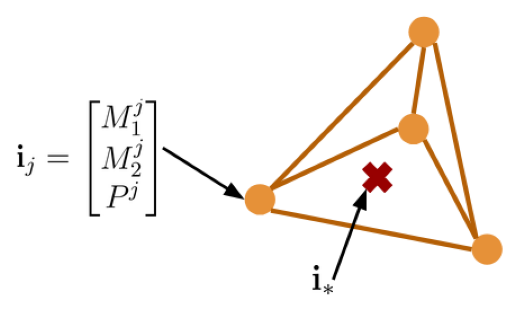

In [4]:
show_figure("barycentric_coordinates.png", "")

These coordinates can easily be computed by solving the set of 4 equations given below, where $a, b, c$, and $d$ correspond to the vertices of the simplex in question:

1. $\lambda_1 M_1^a + \lambda_2 M_1^b + \lambda_3 M_1^c + \lambda M_1^d = M_1^*$
2. $\lambda_1 M_2^a + \lambda_2 M_2^b + \lambda_3 M_2^c + \lambda M_2^d = M_2^*$
3. $\lambda_1 P^a + \lambda_2 P^b + \lambda_3 P^c + \lambda P^d = P^*$
4. $\sum_{i = 1}^4 \lambda_i = 1$

Let's implement this in numpy below!

<div class='alert alert-success'>

### Exercise 2

The `compute_barycentric_coordinates` function below is mosty complete, but you need to find the spot where you will define vertex positions for a tetrahedral and the coordinates of a point that lies inside the tetrahedral, in order to calculate the barycentric weights of that point using this function. Fill these portions of the code in below to complete the function and compute a set of barycentric coordinates.

</div>

In [ ]:
def compute_barycentric_coordinates(point, coords):
    """ Function: compute_barycentric coordinates

        Parameter(s):

        point - np.ndarray: a 3 dimensional vector specifying the position of the point
        coords - np.ndarray: a 4 x 3 matrix where each row corresponds to a point in 3-d space
    """
    T = np.array([
        coords[0] - coords[3],
        coords[1] - coords[3],
        coords[2] - coords[3]
    ]) # our matrix
    T = T.T
    T_I = np.linalg.inv(T)

    r_a = point - coords[3]

    weights = (T_I @ r_a).tolist()

    weights.append(1 - weights[0] - weights[1] - weights[2])

    weights = np.array(weights) / sum(weights)

    return weights

coords = # fill me in!
point = # make sure I am in the tetrahedral!
weights = compute_barycentric_coordinates(point, coords)
print(f"The barycentric weights of our point are: {weights}")

<div class="alert alert-warning" style="margin-top: 20px">
<details>
    
<b><summary>Solution (click to reveal):</summary></b>

```python
coords = np.array([
[0, 0, 0],
[0, 1, 0],
[1, 1/2, 0],
[1/2, 1/2, 1]
])# fill me in!
point = np.array([3/8, 1/2, 1/4])# make sure I am in the tetrahedral!
```

</details>

<div class='alert alert-success'>

### Exercise 2.2 (Optional)
Can you think of an edge-case for which the algorithm would be undefined? Propose an easy solution.

</div>

In [ ]:
# You can write out what you think might work here, or just keep it in your head/discuss with others.

<div class="alert alert-warning" style="margin-top: 20px">
<details>
    
<b><summary>Solution (click to reveal):</summary></b>

If the initial condition does not fall within any tetrahedral, it is outside of the convex hull and can therefore the algorithm described can not be used for interoikation (or in this case, extrapolation). To address this, we use the nearest neighbor as an approximation. Fortunately, this does not happen very often though.
</details>

# 2.0 Using our implementations
Now that we understand the inner workings of our ML methods, we will move on to how our implementations can be used to perform binary simulations and any other systems that require a similar treatment. All implementations related to the ML components can be found in the `posydon.interpolation` module. From there, we can import the `IFInterpolator` class which contains the implementation which is described above, like so.

In [ ]:
from posydon.interpolation.IF_interpolation import IFInterpolator

To construct the `IFInterpolator` class we need to specify two parameters:

1. `grid`: PSyGrid, this is a PSyGrid class instance which contains among other things two important attributes, `initial_values` and `final_values` which respectively correspond to the initial values used by MESA to find the solution to systems of partial differential equations (PDEs) describing the evolution of the binary and the final values which are the parameters describing each star system at the last time step of the solution found using MESA. Although these grids can be generated by a user familiar with the PSyGrid class, we highly recommend that the grids provided by the POSYDON collaboration are used which can be found in the POSYDON_data directory which should have been created during installation.
2. `interpolators`: list, this is a list of dictionaries, each of which contains the specifications to an interpolator. This is useful because we often want to specify a different classification scheme for different parameters (more on this later).

Next, we specify the parameters required by each individual interpolator:

1. `interp_method`: list, the interpolation method to be used can be either 1NN, which uses the final value corresponding to the nearest neighbor as an interpolation method, or linear, which uses the barycentric interpolation. It should be noted that the strings "1NN" and "linear" can be used as values to this parameter, but the interpolator will not have a notion of the different classes. If interpolation only within a class (highly recommended), is desired, then a list of strings must be provided. Each string ("1NN" or "linear") corresponds to a class, and thus the length of this list should be the same as `interp_classes`.

2. `interp_classes`: list, a list of classes that the simulation tracks can
fall into. Usually specified as the mass transfer type. This only needs
be specified if interp_method is a list. Note that when using class-wise normalization 
only classes in interp_classes are normalized. This is the behavior for interpolation normalization
but not classification normalization.

3. `class_method`: str, the classification method to be used, either kNN or
1NN.

4. `in_keys`: list, the keys to be used as the input to the interpolator (initial_values), by default
these are star_1_mass, star_2_mass, and period_days.

5. `out_keys`: list, the keys for which the interpolator is supposed to provide values (final_values),
by default all keys are used.

6. `in_scaling`, list: The scalings for the input keys, by default these scalings are
optimized through Monte Carlo Cross Validation.

7. `out_scaling`, list: The scalings for the output keys, by default these scalings
are optimized through Monte Carlo Cross Validation.

8. `c_keys`, list: A list of strings specifying which classifiers are to be trained

9. `c_key`, str: A string specifying by which class the interpolator should
interpolate binaries. Only to be specified in the MCInterpolator case.

Now, let's use these parameters to construct and train our own instance of the `IFInterpolator`.

In [ ]:
interp = IFInterpolator(grid = grid, interpolators = [
        {
            "interp_method": ["linear", "linear", "linear"], # three methods for three classes
            "interp_classes": ["no_MT", "stable_MT", "unstable_MT"], # classes not in this array will not be normalized in class-wise normalization
            "out_keys": ["star_1_mass"],
            "class_method": "kNN",
            "c_keys": ["interpolation_class"], # specifying that we only wish to train one classifier
            "c_key": "interpolation_class"
        }
    ]
)

interp.train()

To use the interpolator we have a few methods available to us which are listed below:

1. `IFInterpolator.evaluate`: this is the method used by the posydon library but requires an instantiation of the `BinaryStar` class.
2. `IFInterpolator.test_interpolator`: this is the method that is fastest for interpolating binaries and requires an $n \times d$ array where $d$ is the number of initial values (by default 3).
3. `IFInterpolator.test_classsifiers`: this is the method to use when wanting to only use the classification capabilities of the `IFInterpolator`. It requires the same input as `IFInterpolator.test_interpolator` and returns a dictionary where each key is a classification scheme and the value is the class predicted. We haven't explained the classification schemes in detail, but in short, we may want to classify our binary systems based on different criterion, each of which we refer to as a classification scheme. For example, the most commonly used classification scheme involves classifying by MT type, but we might also want to classify by which compact object one of the stars collapses into (either a white dwarf, neutron star, or black hole).

<div class='alert alert-success'>

### Exercise 3

Below is a quick interactive demonstration. To start out, you just need to define some `kwargs` to create a `BinaryStar` object, as we have seen how to do in previous labs.

</div>

In [ ]:
# some quick imports to use the evaluate class
from posydon.binary_evol.singlestar import SingleStar
from posydon.binary_evol.binarystar import BinaryStar

# define star_1 and star_2 to create a binary

binary = BinaryStar(star_1, star_2, **kwargs3)

<div class="alert alert-warning" style="margin-top: 20px">
<details>
    
<b><summary>Solution (click to reveal):</summary></b>

```python
kwargs1 = {"state" : "H-rich_Core_H_burning",
           "mass" : 20.0,
           "metallicity" : 1}

star_1 = SingleStar(**kwargs1)

kwargs2 = {"state" : "H-rich_Core_H_burning",
           "mass" : 10.0,
           "metallicity" : 1}

star_2 = SingleStar(**kwargs2)

kwargs3 = {"state" : "detached",
           "event" : None,
           "time" : 0.,
           "orbital_period" : 3.,
           'eccentricity' : 0.}
```

</details>

In [ ]:
i, c = interp.evaluate(binary) # this  method is the one used within the posydon code
i, c = i["star_1_mass"], c["interpolation_class"]

initial_value = np.array([[44, 13, 365.25]])

i2 = interp.test_interpolator(initial_value) # this method is fastest, but would require batching and is therefore not used in posydon
c2 = interp.test_classifiers(initial_value)["interpolation_class"][0]

print(
    f"Interpolation for initial value {initial_value}: {i}, {i2[0, 0]} \nClassification for initial value: {c}, {c2}"
)

Lastly, we can also save the our `IFInterpolator` instantiation using the `IFInterpolator.save` method like so.

In [ ]:
interp.save("./my_first_interpolator_:).pkl")

Naturally, we can also load in saved instances of the `IFInterpolator` class. Before we load in a class instance which is used within POSYDON, let's discuss the differences in the parameters used to construct an interpolator we use within a binary simulation and the interpolator that we just constructed, trained, and saved. First and foremost, within simulations carried out with POSYDON we are interested in more parameters than just the `star_1_mass`. In fact, we interpolate all final values available to us. However, they are not all interpolated by one interpolator because we want to interpolate different final value parameters with different classification schemes. The vast majority of parameters are interpolated with a MT classification scheme, which is introduced in section 1.0 while the remaining parameters are grouped by super nova (SN) models, resulting in each SN model being treated with its own classification scheme. A pictoral representation of this system can be seen in figure 4.

Source: [2]


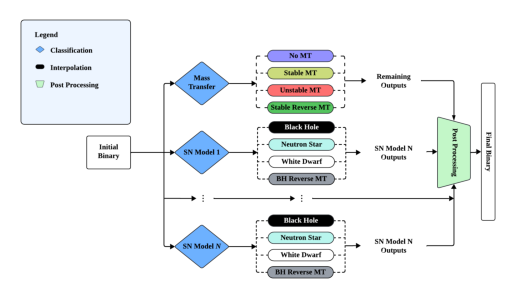

In [5]:
show_figure("./initial_final.png", source="[2]")

Let's load in one of the interpolators we actually use within POSYDON!

In [ ]:
interp_path = "/projects/e33022/POSYDON-shared/data//POSYDON_data/HMS-HMS/interpolators/linear3c_kNN/1e+00_Zsun.pkl"
interp = IFInterpolator()

interp.load(interp_path)

Feel free to play around with the functionality we introduced in the cell below.

In [ ]:
# Now you can use interp to evaluate new binaries as shown above!

# 2.1 How to specify interpolation within our .ini files
Now that we have a good idea of how the `IF_interpolator` can be used as a standalone class, specifying the parameters relevant to it within a population synthesis is very straightforward. A default .ini file can be obtained from `posydon/popsyn/population_params_default.ini`. There, we have to specify parameters for the three phases HMS-HMS, CO-HMS_RLO, and CO-HeMS, which are described in section 1.0. To specify the parameters corresponding to each phase, find lines 18, 48, and 77 in the .ini file, each of which correspond to locations where parameter specifications start for each of the phases, respectively. Within specification block, there are three parameters of importance:

1. `interpolation_path`: this points to a directory where trained interpolators are stored in `.pkl` files and can be found where the `POSYDON_data` directory was specified duirng POSYDON installation (if you are a normal human and don't remember, type `echo $PATH_TO_POSYDON_DATA` in a terminal). The interpolation path can then be specified as `PATH_TO_POSYDON_DATA/<phase_name>/interpolators/<interpolation_method>/<interpolation_filename>`, where the `<phase_name>` corresponds to one of the remianing parameters in angle brackets are specified subsequently.
2. `interpolation_filename`: This string specifies the metalicty by specifyiong the filename as `<metallicity>.pkl`.
3. `interpolation_method`: This string provides the method used. There are two options, either `1NN_1NN` or `linear3c_kNN`. The first uses the naiive nearest neighbor method and the second uses the barycentric interpolation. Both methods utilize the classification specified in section 1.1

A snippet of a parameter specification block for the HMS-HMS phase can be seen below.

```python
[step_HMS_HMS]
...
interpolation_path = None
# str or None (found by default)
interpolation_filename = None
# str or None (found by default)
interpolation_method = 'linear3c_kNN'
# 'nearest_neighbour', 'linear3c_kNN', '1NN_1NN'
...
```

## 2.2 Evolving populations

In theory, and according to our evaluation methods shown in [2], `linear3c_kNN` is the more accurate method by far. A natural question is how this impacts an entire binary evolution. Thus, in this part of the practicum, you will be using some of the skills you've aquired in previous practicums to compare and contrast the `linear3c_kNN` and the `1NN_1NN` methods for bianry evolution. We have prepared two .ini files named linear3c_kNN.ini anf 1NN_1NN.ini, each of which has a the linear3c_kNN and the 1NN_1NN method specified for usage, respectively. 

<div class='alert alert-success'>

### Exercise 4

Please use the cells below to compare the outputs of the two different populations. You just need to create `BinaryPopulation` classes for the `linear3c_kNN` and `1NN_1NN` cases described above, using the prepared .ini files.

</div>

In [ ]:
import os
os.environ["PATH_TO_POSYDON_DATA"] = "/projects/e33022/POSYDON-shared/data/"
os.environ["PATH_TO_POSYDON"] = "/projects/e33022/POSYDON-shared/POSYDON/"

from posydon.popsyn.binarypopulation import BinaryPopulation

linear3c = # which method should be used to load in the ini file at './linear3ckNN.ini'?
_1NN1NN = # which method should be used to load in the ini file at './1NN_1NN.ini'?

<div class="alert alert-warning" style="margin-top: 20px">
<details>
    
<b><summary>Solution (click to reveal):</summary></b>

```python
    linear3c = BinaryPopulation.from_ini('./linear3ckNN.ini')
    _1NN1NN = BinaryPopulation.from_ini('./1NN_1NN.ini')
```

</details>

Evolve and save the populations in the next two cells.

In [ ]:
linear3c.evolve()
linear3c.save("./linear3c_population.h5")

In [ ]:
_1NN1NN.evolve()
_1NN1NN.save("./1NN_1NN_population.h5")

Use the cells below to compare the two populations!

In [ ]:
from posydon.popsyn.synthetic_population import Population

pop_l3c = Population("./linear3c_population.h5")
pop_1nn = Population("./1NN_1NN_population.h5")

# 3.0 Concluding Remarks
Although simple, the algorithms presented within this tutorial are interpetable and quite powerful when paired with our high resolution grids. This makes their usage within POSYDON highly desirable, as they can also easily be utilized to evolve binary evolutions with our .ini files. However, as we saw earlier in the practicum, these methods are not limited to applications within POSYDON and can be extended to solve any sort of problem that can be formulated as a regression task, particularly those that require a highly interpretable system. Therefore, we encourage users to use our code not only for POSYDON related tasks, but also for any project that requires the functionality this system provides. Furthermore, we are always happy to assist users in using our software and thus, if any help is desired from our team, please do not hesitate to reach out.

References <br /> <br />
[1] Tauris, T. M. and van den Heuvel, E. P. J., Physics of Binary Star Evolution. From Stars to X-ray Binaries and Gravitational Wave Sources. 2023. doi:10.48550/arXiv.2305.09388. <br />
[2] Andrews, J. J., “POSYDON Version 2: Population Synthesis with Detailed Binary-Evolution Simulations across a Cosmological Range of Metallicities”, arXiv e-prints, Art. no. arXiv:2411.02376, 2024. doi:10.48550/arXiv.2411.02376. <br />
[3] Paxton, B., Bildsten, L., Dotter, A., Herwig, F., Lesaffre, P., and Timmes, F., “Modules for Experiments in Stellar Astrophysics (MESA)”, The Astrophysical Journal Supplement Series, vol. 192, no. 1, Art. no. 3, 2011. doi:10.1088/0067-0049/192/1/3. <br />
[4]Berrut, J.-P. and Trefethen, L. N., “Barycentric Lagrange Interpolation”, <i>SIAM Review</i>, vol. 46, no. 3, pp. 501–517, 2004. doi:10.1137/S0036144502417715. <br />
[5] C. B. Barber, D. P. Dobkin, and H. Huhdanpaa, “The quickhull algorithm for convex hulls,” ACM Transactions on Mathematical Software, vol. 22, no. 4, pp. 469–483, Dec. 1996, doi: https://doi.org/10.1145/235815.235821.

